# Partie 3 : Analyse et comparaison des embeddings textuels

## Traduction des descriptions

In [6]:
import pandas as pd
from datasets import load_dataset
from transformers import pipeline
import torch
from pathlib import Path

In [7]:
# Charchement du dataset
ds = load_dataset("DBQ/Chanel.Product.prices.Germany")
df = ds["train"].to_pandas()

In [8]:
ds = load_dataset("DBQ/Chanel.Product.prices.Germany")
df = ds["train"].to_pandas()

df = df[df["title"] != "n.a."]

image_dir = Path("../data/images")

df["has_image"] = df.index.map(lambda i: (image_dir / f"{i}.jpg").exists())
df = df[df["has_image"]]

df["image_id"] = df.index
df = df.reset_index(drop=True)

# Filtrer classes qui ont au moins 5 images
counts = df["category2_code"].value_counts()
valid_classes = counts[counts >= 5].index
df = df[df["category2_code"].isin(valid_classes)]

print("Taille du dataset nettoyé :", df.shape)



Taille du dataset nettoyé : (868, 19)


In [9]:
# Charchement du model de traduction
translator_DE = pipeline("translation", model="Helsinki-NLP/opus-mt-de-en")

Device set to use cpu


In [10]:
# Fonction de traduction vers l'anglais
def translate_to_ENG(text):
    if pd.isna(text) or str(text).strip() == "":
        return ""
    if len(str(text)) > 500:
        print(".")

    try:
        result = translator_DE(str(text), max_length=500)[0]['translation_text']
        return result  
    except Exception as e:
        print(f"Erreur lors de la traduction: {e}")
        return str(text)

In [11]:
# Application de la traduction dans une nouvelle colonne
df['title_eng'] = df['title'].apply(translate_to_ENG)

In [12]:
# Affichage des 5 premières valeurs du dataframe
df[['title', 'title_eng']].head(10)   

,title,title_eng
0,Tweed & goldfarbenes Metall Schwarz Rosa & B...,Tweed & Gold Metal Black Pink & Bordeaux
1,Schwarz,Black
2,Silberfarben. Gläser: Braun Mit Verlauf,Silver colors. Glasses: Brown With course
3,Blau & Rosa. Gläser: Grau Mit Verlauf,Blue & Pink. Glasses: Grey with course
4,Schwarz. Gläser: Grau Mit Verlauf,Black. Glasses: Grey with course
5,Rosa & Weiß. Gläser: Rosa,Pink & White. Glasses: Pink
6,Silberfarben. Gläser: Bordeaux,Silver Colors. Glasses: Bordeaux
7,Steppmotiv kleines Modell 18 Karat Gelbgold ...,Stepp motif small model 18K yellow gold diamonds
8,Goldfarben,Gold colours
9,Schwarz,Black


## Génération des embeddings textuels

In [13]:
from transformers import AutoTokenizer, AutoModel
import numpy as np

In [14]:
# Tokenization et chargement du model BERT pré-entrainés
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [15]:
batch_size=16

In [16]:
# Fonction d'extraction des embbedings BERT
def embeding_BERT(texts, pool):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        inputs = {k: v.to('cpu') for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
        outputs = output.last_hidden_state
        
        if pool == "moy":
            attention_mask = inputs['attention_mask']
            input_mask = attention_mask.unsqueeze(-1).expand(outputs.size()).float()
            embedding = torch.sum(outputs * input_mask, 1) / torch.clamp(input_mask.sum(1), min=1e-10)
        elif pool == "cls":
            embedding = outputs[:, 0, :]
        elif pool == "max":
            attention_mask = inputs['attention_mask']
            input_mask = attention_mask.unsqueeze(-1).expand(outputs.size()).float()
            outputs[input_mask == 0] = -np.inf
            embedding = torch.max(outputs, 1)[0]
        else:
            print(f"{pool} : stratégie de pooling non disponible (moy, cls ou max)")
            return
        embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)

In [17]:
# Option d'embbeding : moyenne des tokens (moy), 1er token (cls), max pooling des tokens (max) 
embedding_moy = embeding_BERT(df['title_eng'].astype(str).tolist(), pool="moy")
embedding_cls = embeding_BERT(df['title_eng'].astype(str).tolist(), pool="cls")
embedding_max = embeding_BERT(df['title_eng'].astype(str).tolist(), pool="max")

In [18]:
# Ajout de colonnes dans le dataset pour l'embbeding
df['embeddings_moy'] = list(embedding_moy)
df['embeddings_cls'] = list(embedding_cls)
df['embeddings_max'] = list(embedding_max)

In [19]:
# Visualisation des différentes tokenisation
df[['title_eng','embeddings_moy', 'embeddings_cls','embeddings_max']].head(6)

,title_eng,embeddings_moy,embeddings_cls,embeddings_max
0,Tweed & Gold Metal Black Pink & Bordeaux,"[0.6184224, -0.25984523, 0.318039, -0.04415295...","[-0.3044762, -0.4492401, -0.1640249, 0.0040488...","[1.4206896, 0.68131816, 1.0760252, 0.42791674,..."
1,Black,"[0.3181308, 0.076377906, -0.5111589, -0.033018...","[-0.103923276, 0.18604061, -0.4443168, -0.1212...","[0.9050711, 0.18604061, -0.4443168, 0.48152632..."
2,Silver colors. Glasses: Brown With course,"[-0.06995819, -0.25765786, 0.08004902, -0.1028...","[-0.41662776, -0.2122477, -0.081956744, 0.2793...","[1.0473562, 0.30401185, 0.91500807, 0.572952, ..."
3,Blue & Pink. Glasses: Grey with course,"[0.052519366, -0.23147021, 0.48186362, -0.2302...","[-0.07238094, -0.17260894, 0.198589, 0.0480221...","[1.0432304, 0.36028033, 1.508986, 0.39334184, ..."
4,Black. Glasses: Grey with course,"[0.14887477, -0.00045559474, 0.20205885, -0.32...","[-0.11541344, -0.07279174, 0.035738327, -0.002...","[0.96055335, 0.551238, 0.85877293, 0.43560654,..."
5,Pink & White. Glasses: Pink,"[-0.13378502, -0.35408688, 0.08456811, -0.1830...","[-0.26443118, -0.40659624, 0.0033176765, 0.007...","[1.0106055, 0.23667133, 0.85319644, 0.44447473..."


## Analyse des embeddings

In [20]:
import numpy as np

In [21]:
# Choix de la moyenne des tokens pour l'analyse
embeddings = np.vstack(df['embeddings_moy'].values)

In [22]:
# Calcul de la similarité entre les embbedings
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
similarity = np.dot(embeddings_norm, embeddings_norm.T)

In [23]:
# Fonction de comparaison entre 2 éléments du dataset
def comparaison(A, B):
    print(df.iloc[A]['category2_code'])
    print(df.iloc[B]['category2_code'])
    print(f"Similarité de {float(similarity[A][B]*100):0.3f}%")

In [24]:
# Comparaison entre paires de lunettes
comparaison(3, 4)
# Comparaison entre une paires de lunettes et un vêtement
comparaison(700, 4)

SUNGLASSES
SUNGLASSES
Similarité de 89.667%
SMALL LEATHER GOODS
SUNGLASSES
Similarité de 65.064%


## Visualisation

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans

In [26]:
# Fonction de réduction des dimmensions de l'embbeding : pca ou t-SNE
def reduct_dim(embeddings, method):
    if method == "pca":
        pca = PCA(n_components=2, random_state=42)
        embeddings_reduct = pca.fit_transform(embeddings)
    elif method == "tsne":
        tsne = TSNE(random_state=42)
        embeddings_reduct = tsne.fit_transform(embeddings)
    return embeddings_reduct

In [27]:
# Calcul de l'embbeding 2D
embeddings_2D = reduct_dim(embeddings, "tsne")

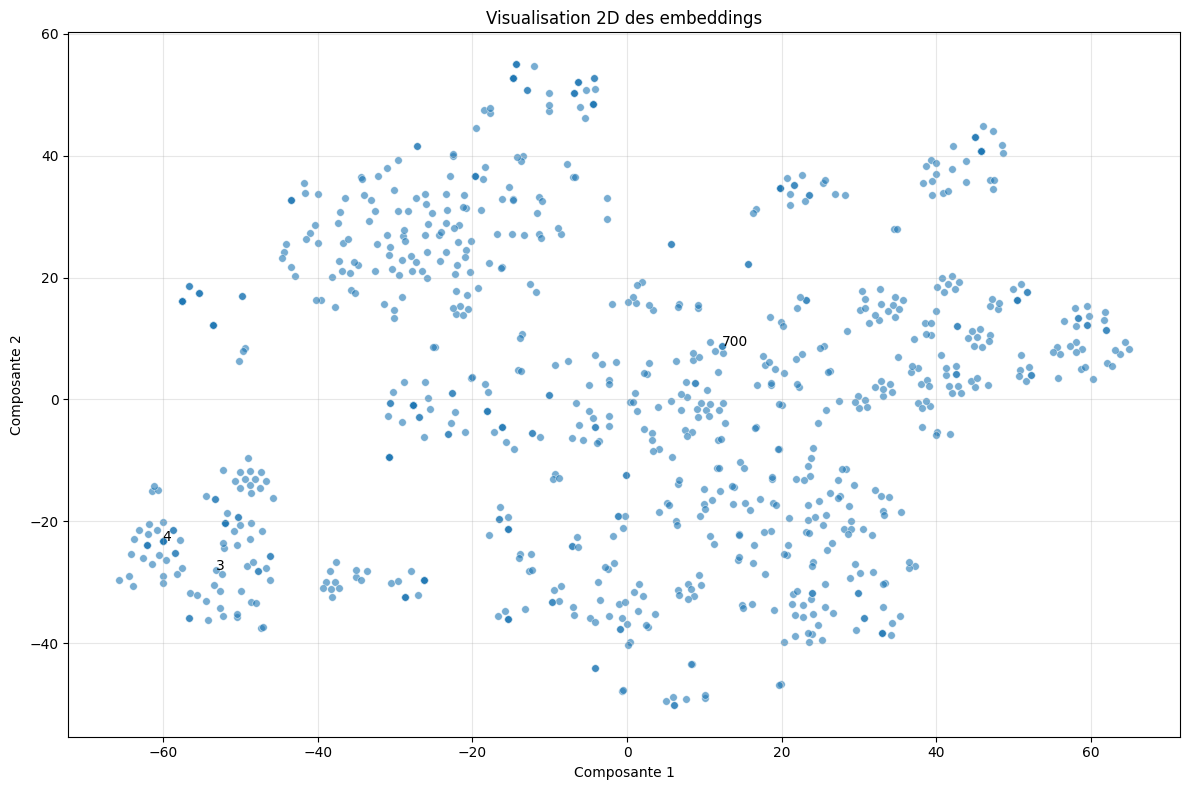

In [28]:
# Visualisation des embbedings 2D
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2D[:, 0], embeddings_2D[:, 1], 
                      alpha=0.6, s=30, edgecolors='w', linewidth=0.5)
index = np.array([3, 4, 700])
for i in index:
    plt.annotate(f"{i}", (embeddings_2D[i, 0], embeddings_2D[i, 1]))
plt.title(f'Visualisation 2D des embeddings')
plt.xlabel(f'Composante 1')
plt.ylabel(f'Composante 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calcul des clusters des embbedings 2D
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_2D)

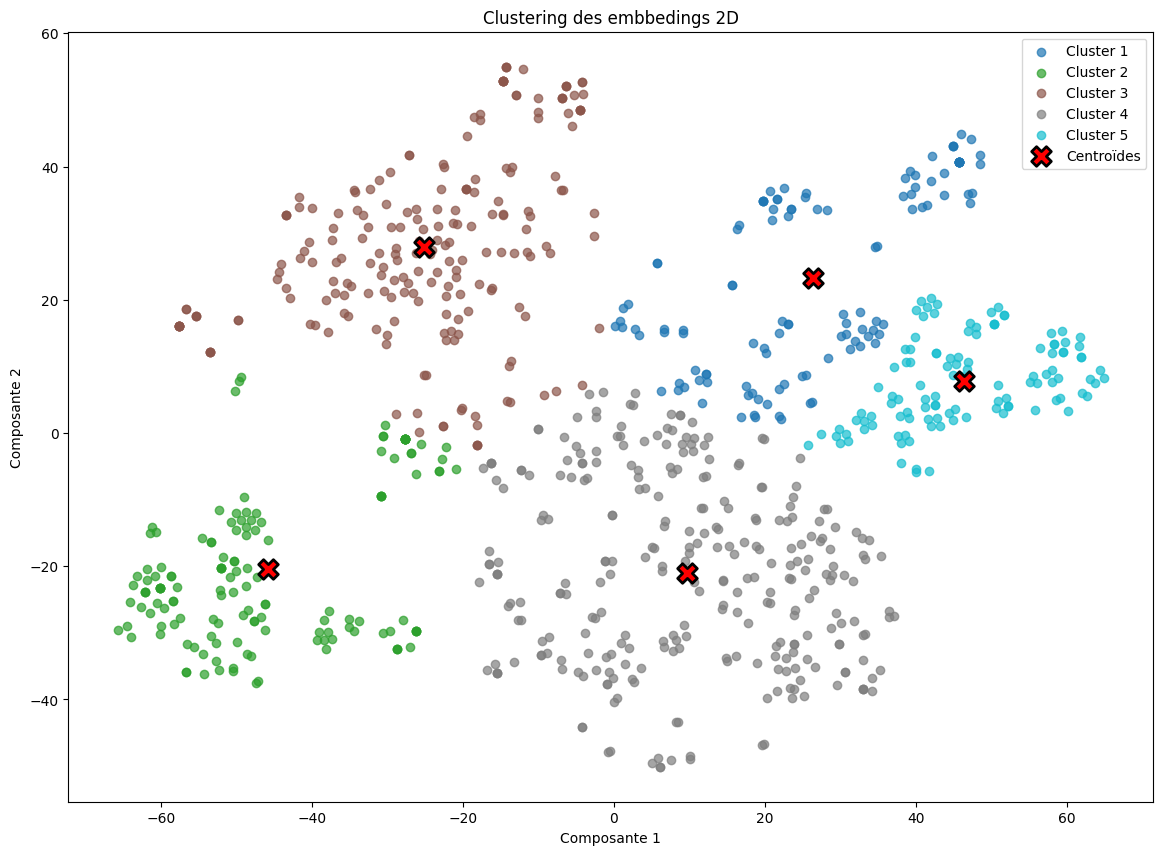

In [30]:
# Visualisation des clusters des embbedings 2D
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, kmeans.n_clusters))
for cluster_id in range(kmeans.n_clusters):
    show = clusters == cluster_id
    plt.scatter(embeddings_2D[show, 0], embeddings_2D[show, 1],
                color=colors[cluster_id], label=f"Cluster {cluster_id+1}", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='X', s=200, c='red', label='Centroïdes', edgecolors='black', linewidth=2)
plt.title("Clustering des embbedings 2D")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.legend()
plt.show()

In [31]:
# Code pour PARTIE 4
import numpy as np
import pandas as pd
from pathlib import Path

# -------------------------------------------------------------
# 1) Création du dossier data/ si nécessaire
# -------------------------------------------------------------
SAVE_DIR = Path("../data")
SAVE_DIR.mkdir(exist_ok=True)

# -------------------------------------------------------------
# Construction du dataframe meta
# -------------------------------------------------------------
meta = pd.DataFrame()

# Utiliser l'ancien index → le seul qui correspond aux fichiers images
meta["id"] = df["image_id"]

# Titre original + titre traduit
meta["title"] = df["title"].astype(str)
meta["title_eng"] = df["title_eng"].astype(str)

# Infos utiles
meta["category2_code"] = df["category2_code"]
meta["price_eur"] = df["price_eur"]

# Chemin d'image correct
meta["image_path"] = meta["id"].apply(lambda i: f"data/images/{i}.jpg")

print(meta.head())


# -------------------------------------------------------------
# 5) Sauvegarde du meta.pkl
# -------------------------------------------------------------
meta.to_pickle(SAVE_DIR / "meta.pkl")
print("Meta sauvegardé → data/meta.pkl")

np.save(SAVE_DIR / "embeddings_text.npy", embedding_moy)
print("Embeddings textuels sauvegardés → data/embeddings_text.npy")



   id                                              title  \
0   0  Tweed & goldfarbenes Metall  Schwarz  Rosa & B...   
1   2                                            Schwarz   
2   3           Silberfarben. Gläser: Braun  Mit Verlauf   
3   4             Blau & Rosa. Gläser: Grau  Mit Verlauf   
4   5                 Schwarz. Gläser: Grau  Mit Verlauf   

                                   title_eng      category2_code  price_eur  \
0   Tweed & Gold Metal Black Pink & Bordeaux            HANDBAGS     5200.0   
1                                      Black  BLUE LIGHT GLASSES      420.0   
2  Silver colors. Glasses: Brown With course          SUNGLASSES      580.0   
3     Blue & Pink. Glasses: Grey with course          SUNGLASSES      480.0   
4           Black. Glasses: Grey with course          SUNGLASSES      620.0   

          image_path  
0  data/images/0.jpg  
1  data/images/2.jpg  
2  data/images/3.jpg  
3  data/images/4.jpg  
4  data/images/5.jpg  
Meta sauvegardé → data/met

In [32]:
meta[meta["title_eng"].str.contains("Adjustable Long Collier", case=False)]


,id,title,title_eng,category2_code,price_eur,image_path
